In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from mplsoccer.pitch import Pitch, add_image
from scipy.special import factorial
import seaborn as sns
from PIL import Image
sns.set(font_scale=2)
from urllib.request import urlopen
sns.set_style("whitegrid")
%config InlineBackend.figure_format='retina'

In [2]:
EVENTS_PATH = os.path.join('..','data','statsbomb','event.parquet')
df_events = pd.read_parquet(EVENTS_PATH)

In [3]:
team_goals_from_events = df_events[((df_events.outcome_name=='Goal')|
                                    (df_events.type_name=='Own Goal For'))&(df_events.period!=5)]
team_goals_from_events = pd.DataFrame(team_goals_from_events.groupby(['match_id'])
                                      .id.nunique()).reset_index()
team_goals_from_events.rename({'id':'goals'},axis=1,inplace=True)
df_games = df_events[['match_id']].drop_duplicates()
df_games = df_games.merge(team_goals_from_events, how='left').fillna(0)
df_games['goals'] = df_games['goals'].astype(np.int32)

In [4]:
n_games = len(df_games)

In [5]:
average_goals_per_game = df_games.goals.mean().round(2)

In [6]:
goals = df_games.goals.sum()

In [7]:
print(n_games, goals, average_goals_per_game)

855 2768 3.24


In [8]:
goals_per_game = df_games['goals'].value_counts().sort_index()
goals_per_game.index.name = 'goals in game'
df_goals_per_game = goals_per_game.reset_index()

In [9]:
goals_from = goals_per_game.index.min()
goals_to = goals_per_game.index.max()

In [10]:
t = np.arange(goals_from, goals_to+1, 1)
d = np.exp(-average_goals_per_game)*np.power(average_goals_per_game, t)/factorial(t)
goal_dist = (d * n_games).round(0)

In [11]:
df_predicted = pd.DataFrame({'goals in game':t,f'predicted via Poisson({average_goals_per_game})':goal_dist})

In [12]:
df_predicted = (df_predicted.merge(df_goals_per_game,how='outer')
                .fillna(0)
                .rename({'total_goals':'actual'},axis=1).set_index('goals in game')
                .sort_index())

In [13]:
IMAGE_URL = 'https://github.com/statsbomb/open-data/blob/master/stats-bomb-logo.png?raw=true'
logo = np.array(Image.open('SB_Regular.png'))

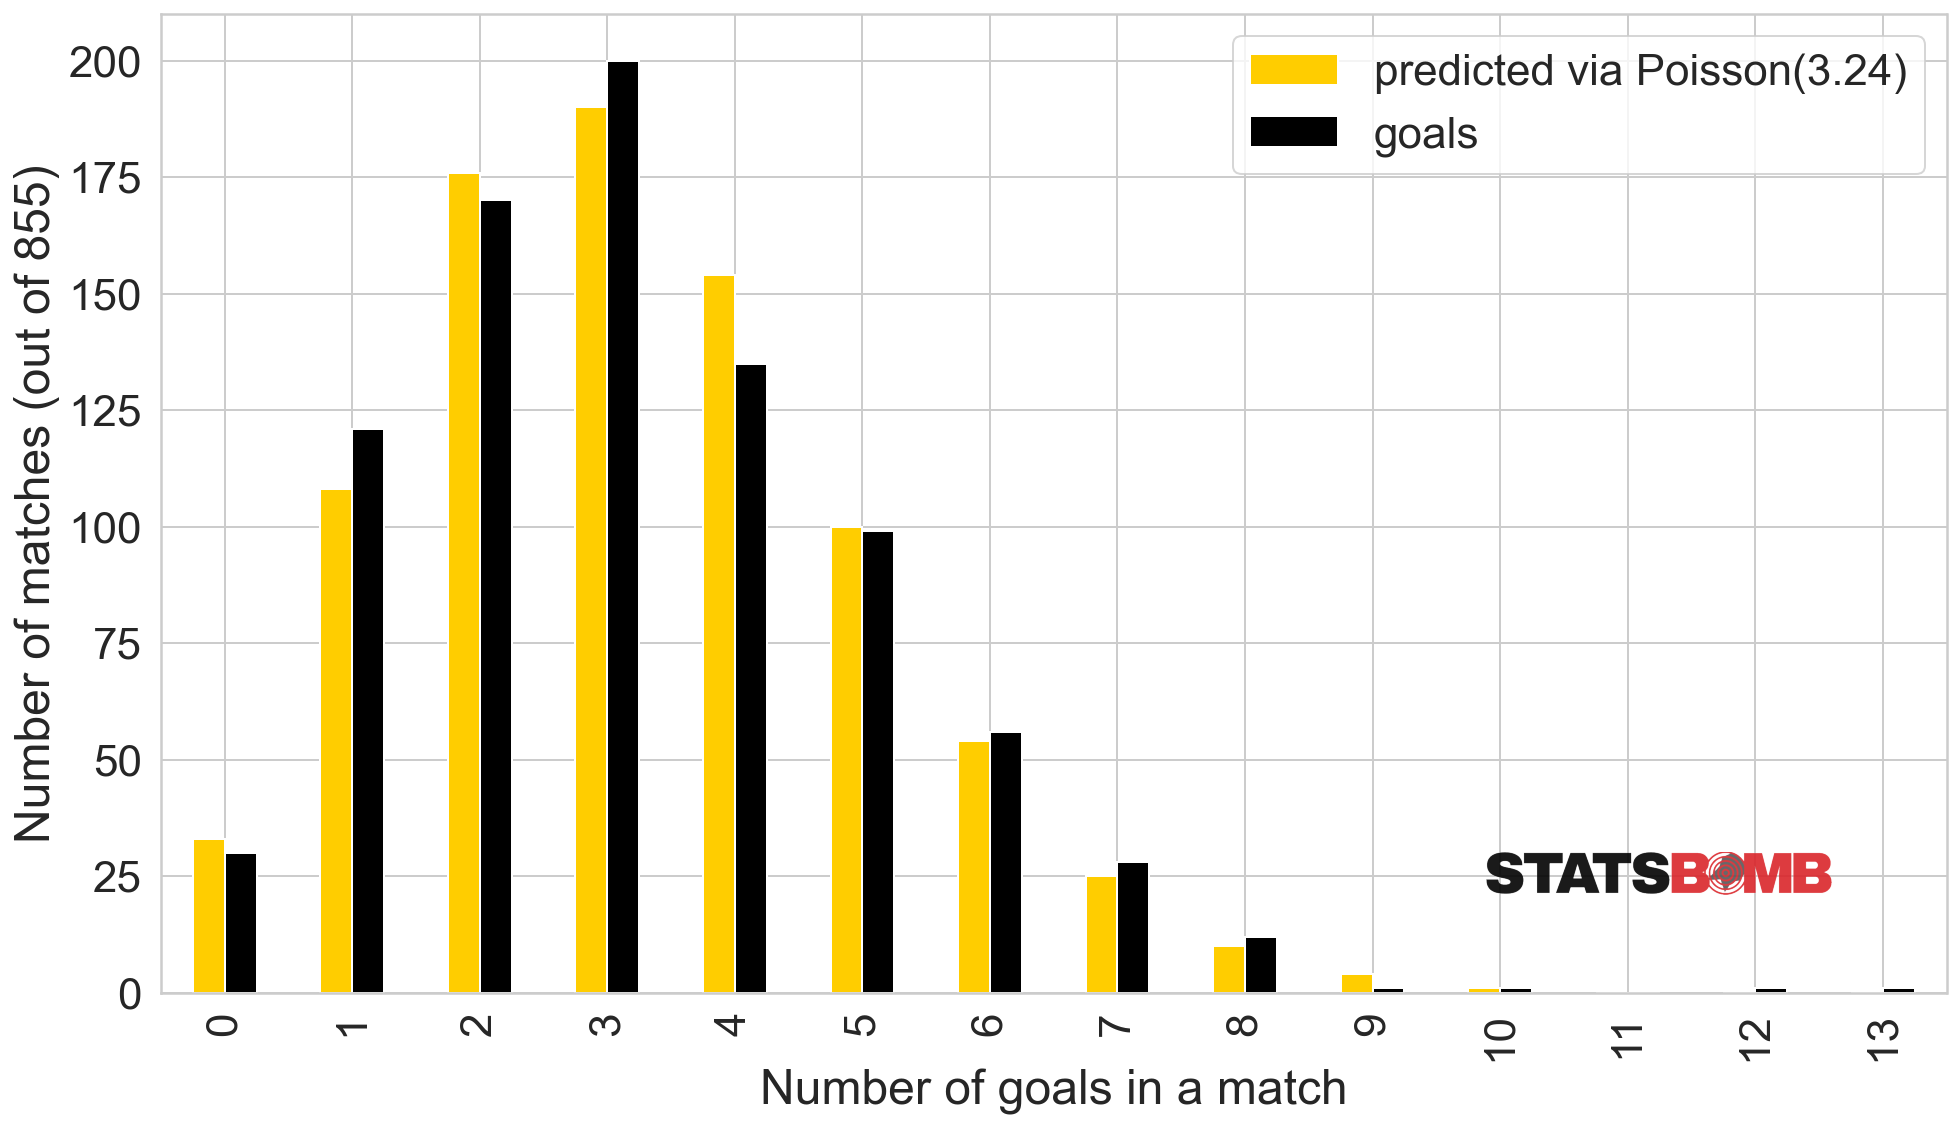

In [14]:
fig,ax = plt.subplots(figsize=(16,9))
df_predicted.plot(kind='bar',color=['#ffcd00','black'],ax=ax)
ax.set_xlabel('Number of goals in a match')
ax.set_ylabel(f'Number of matches (out of {n_games})')
ax_image = add_image(logo, fig, left=0.7, bottom=0.2, width=0.15, alpha=0.9, interpolation='hanning')
fig.savefig(os.path.join('..', 'figures', '01_goals_follow_poisson_dist.png'), bbox_inches = 'tight', pad_inches = 0.2)